# [量子計算を用いた文字言語モデル](https://www.anlp.jp/proceedings/annual_meeting/2024/pdf_dir/B7-6.pdf)<br>
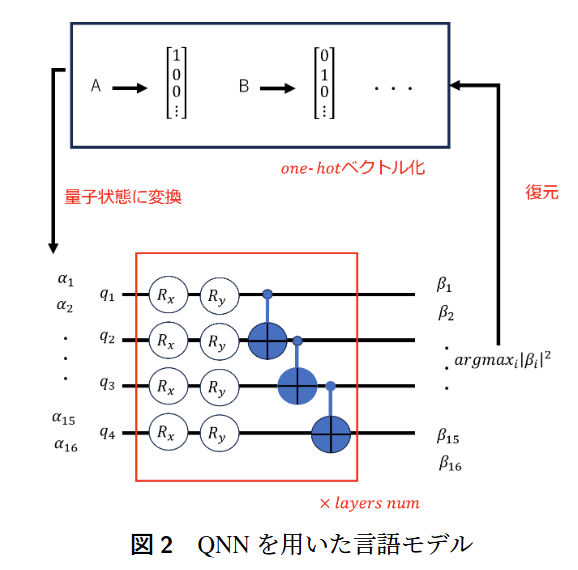

In [170]:
import os
import sys
import random
import math
import numpy as np

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms

import pennylane as qml
from pennylane import numpy as np

#from tqdm.notebook import tqdm
#import h5py
#from einops.layers.torch import Rearrange
#from einops import rearrange, repeat


seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.set_printoptions(edgeitems=1e3)

device = 'cuda'

In [171]:
torch.cuda.is_available()

True

## データセット

In [172]:
# [参考] 世界モデル day7 の演習

class CharDataset(Dataset):
    def __init__(self, data, n, dim_emb) -> None:
        """
        Parameters
        ----------
        data : str
            文章．今回は文字数約100万のテキストデータ
        block_size : int
            モデルに入力する最大系列長
        """
        # set型は重複しない要素のコレクション
        chars = sorted(list(set(data)))

        data_size, vocab_size = len(data), len(chars) # 1115394, 65
        print('Data has %d characters, %d unique:' % (data_size, vocab_size))
        print(chars)

        # 文字を0~64の数字にマップする辞書
        self.stoi = {ch: i for i, ch in enumerate(chars)}
        # 逆に, 数字を65種類の文字にマップする辞書
        self.itos = {i: ch for i, ch in enumerate(chars)}

        #self.block_size = block_size
        self.vocab_size = vocab_size # 65
        self.data = data
        self.n = n
        self.dim_emb = dim_emb

    def __len__(self):
        #return len(self.data) - self.block_size
        return len(self.data) - self.n
    
    def __getitem__(self, idx):
        """
            x: idx 直前の n 文字
            y: idx の文字
        """
        # TODO
        x_list = [ self.stoi[s] for s in self.data[(idx - self.n + 1):idx] ]
        y_list = [ self.stoi[self.data[idx]] ]

        x = np.zeros(self.dim_emb)
        y = np.zeros(self.dim_emb)

        x[x_list] = 1
        y[y_list] = 1

        x = torch.tensor(x, dtype=torch.float64)
        y = torch.tensor(y, dtype=torch.float64)

        return x, y



    #def __getitem__(self, idx):
    #    """
    #    テキスト形式のまま保持しているself.dataからblock_sizeの長さの文字列を
    #    切り出し，vocabulary内のインデックスに変換して返す．
#
    #    Parameters
    #    ----------
    #    idx : int
    #        テキストデータから切り出しを始める文字のインデックス
#
    #    Returns
    #    ----------
    #    x : torch.Tensor ( block_size (= t), )
    #        モデルに入力されるインデックス系列
    #    y : torch.Tensor ( block_size (= t), )
    #        ターゲットのインデックス系列．xが一つ前にずれたもの．
    #    """
    #    # idxから始まる長さblock_size + 1の文字列を切り出す．
    #    chunk = self.data[idx:idx + self.block_size + 1] # 例: 'First, '
#
    #    # 抜き出した文字列を一つずつインデックスにマッピングする．
    #    dix = [self.stoi[s] for s in chunk] # 例: [18, 47, 56, 57, 58, 1, ...]
#
    #    x = torch.tensor(dix[:-1], dtype=torch.long)
    #    y = torch.tensor(dix[1:], dtype=torch.long)
#
    #    return x, y

In [173]:
os.getcwd()

'D:\\Project\\QML'

In [174]:
n_qubits = 7
n_basic_entangler_layers = 8

In [175]:
#block_size = 128 # コンテクストの長さ
n = 64

# 事前学習用データセット. ファイルは1.1MB程度です.
text = open('./1_QuCharModel/data/shakespeare.txt', 'r').read()
train_dataset = CharDataset(text, n, 2**n_qubits)
print()

print('=============最初の147文字==============')
print(text[:147])

Data has 1115394 characters, 65 unique:
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

=============最初の147文字==============
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?


In [176]:
x, y = train_dataset[n]
x.shape, y.shape

(torch.Size([128]), torch.Size([128]))

## モデル定義

### 量子層

In [177]:
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    #inputs = inputs + 1e-6
    #print(f"inputs:{inputs}")
    qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True)       # TODO: inputsについて、前段にnn.embedding挟んでword embeddingを入力したいが、ひとまず論文にならいone-hotで入力
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))            # 層数はweightsの1次元目で決まる
    
    return qml.state()
    #return np.abs(qml.state())
    #return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

weight_shapes = {"weights": (n_basic_entangler_layers, n_qubits)}

qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

In [178]:
# 回路図

sample_x, sample_y = train_dataset[n]


qml.drawer.use_style('black_white')
drawer = qml.draw(qnode)
print(drawer(sample_x, np.random.normal(0, np.pi, size=(n_basic_entangler_layers, n_qubits))))


0: ─╭|Ψ⟩─╭BasicEntanglerLayers(M0)─┤  State
1: ─├|Ψ⟩─├BasicEntanglerLayers(M0)─┤  State
2: ─├|Ψ⟩─├BasicEntanglerLayers(M0)─┤  State
3: ─├|Ψ⟩─├BasicEntanglerLayers(M0)─┤  State
4: ─├|Ψ⟩─├BasicEntanglerLayers(M0)─┤  State
5: ─├|Ψ⟩─├BasicEntanglerLayers(M0)─┤  State
6: ─╰|Ψ⟩─╰BasicEntanglerLayers(M0)─┤  State

M0 = 
[[ 1.70821952 -1.93342964 -3.76301987  6.7282184  -0.29726064 -2.91799954
  -2.78103315]
 [-1.2949283  -1.51619167  0.51573899  0.73229029  0.37069101  4.59419636
   4.83401564]
 [-7.66267691  1.89576652 -0.78867789 -0.51480373 -4.63802652  4.67148845
  -0.07682821]
 [ 1.11699741  1.31007904  2.61525605 -0.9217406  -0.09374063  0.29884647
   2.0880732 ]
 [-0.4405094  -0.10428014 -2.3532933  -2.4453592   2.98087775  4.96638859
  -1.15664312]
 [ 1.17987109 -3.74841713 -1.28507445 -1.40347972  4.78854632  1.01473379
  -4.37754842]
 [-6.84343887 -3.27949729  0.54253328  1.01850047  2.34318686 -5.76979641
   1.77331671]
 [ 0.08011271  1.48658044  2.07090834  7.35367149  3.3645992  

### モデル全体

In [179]:
class QuCharModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qlayer
        self.softmax = nn.Softmax(dim=0)

    def forward(self, x):
        #print(f"x:{x}")
        #print(f"self.qlayer(x):{self.qlayer(x)}")
        x = torch.abs(self.qlayer(x))
        #print(x)
        x = self.softmax(x)

        return x

## 学習

In [180]:
len(train_dataset)

1115330

In [ ]:
model = QuCharModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 1000
n_data = 10000

for epoch in range(epochs):
    epoch_loss = 0

    #for i in range(n, len(train_dataset)):
    for i in range(n, n_data+1):
        x, y = train_dataset[i]   # torch.Size([2**n_qubits]), torch.Size([2**n_qubits])
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        output = model(x)
        if i % n_data == 0:
            print(f"--- {i} / {n_data} ---")
            print(f"x:{x}")
            print(f"y:{y}")
            print(f"output:{output}")
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    #print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_dataset)}')
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/(n_data-n)}')